In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW

# Lucas Schmidt Ferreira de Araujo

## Problem 01

One has

$$ f(x) = \int_{0}^1 k(x,y) u(y) dy $$

Such that 

$$
k(x,y) = 
\begin{cases}
\frac{y}{T}(1-x), \quad y \in [0,x]\\
\frac{x}{T}(1-y), \quad y \in (x,1]
\end{cases}
$$

$$
k_x(x,y) = 
\begin{cases}
-\frac{y}{T}, \quad y \in [0,x]\\
\frac{1}{T}(1-y), \quad y \in (x,1]
\end{cases}
$$

$$ k_{xx}(x,y) = 0$$
The problem can be written as 

$$ f(x) = \int_{0}^x k(x,y) u(y) dy +  \int_{x}^1 k(x,y) u(y) dy$$

Then

$$ f'(x) = k(x,x)u(x) + \int_{0}^{x} \partial_x k(x,y)u(y)dy - k(x,x)u(x) + \int_{x}^{1} \partial_x k(x,y)u(y)dy$$

$$ f''(x) = \partial_x k(x,x) u(x) - \partial_x k(x,x) u(x) + \int_{0}^{x} \partial_{xx} k(x,y)u(y)dy - k(x,x)u(x) + \int_{x}^{1} \partial_{xx} k(x,y)u(y)dy $$

$$ f''(x) = -\frac{x}{T}u(x) - \frac{1}{T}(1-x)u(x) = - \frac{u(x)}{T}$$

Then, one has
$$
\begin{cases}
T f''(x) + u(x) = 0 \\
f(0) = f(1) = 0
\end{cases}
$$


If we make 

$$ f(x) = (x-1) sin(x) \implies f''(x) = 2 \cos(x) + \sin(x)(1-x) $$
$$ f_{\delta}(x) =  (x-1) \sin(x)  + \delta(x-1) \sin(x/ \delta) \implies f''_{\delta}(x) = f''(x) + \frac{1}{\delta} \sin(\frac{x}{\delta})(1-x)$$

## Ill- posed

One has in the $L^{\infty}$ norm:

$$ \Vert f(x) - f_{\delta}(x) \Vert_{L^{\infty}} = \sup_{x \in [0,1]}\delta (x-1) \sin(x/\delta) \leq \delta \rightarrow 0, \quad as \quad  \delta \rightarrow 0$$

$$ \Vert u(x) - u_{\delta}(x) \Vert_{L^{\infty}} = T \Vert f''_{\delta}(x) - f''(x) \Vert_{L^{\infty}} = T \Vert \frac{1}{\delta} \sin(x/\delta)(1-x) \Vert_{L^{\infty}} \geq \frac{1}{\delta} \rightarrow \infty, \quad \delta \rightarrow 0$$

In [2]:
function f(x)
    return (x-1) * sin(x)
end

function fδ(x , δ = .01)
    return f(x) + δ*(x-1) * sin(x/δ)
end

function u(x)
    return -T*( 2*cos(x) + sin(x) *(1-x))
end

function uδ(x,δ =.01)
    return u(x) - T * sin(x/δ) * (1-x) / δ
end

uδ (generic function with 2 methods)

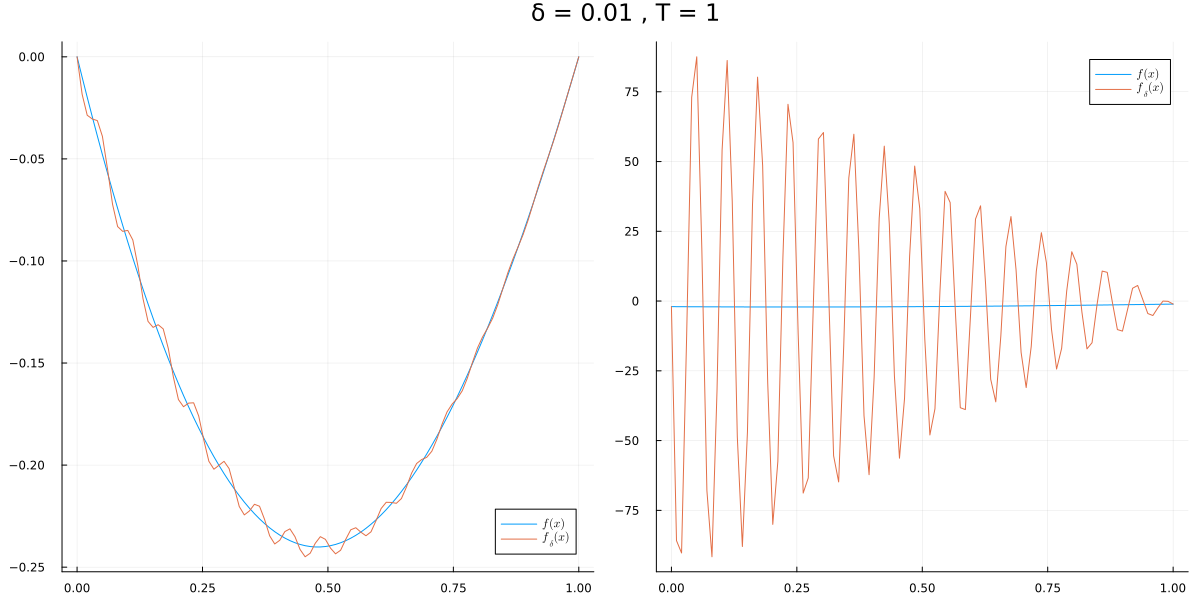

In [3]:
T = 1
δ = .01
x = range(0,1,100)

p1 = plot( x , f.(x) , label = L"f(x)")
plot!( x , fδ.(x, Ref(δ)) , label = L"f_{δ}(x)")

p2 = plot(x , u.(x), label = L"f(x)")
plot!( x , uδ.(x , Ref(δ)), label = L"f_{δ}(x)")

plot( p1 , p2 , size = (1200,600) , suptitle = "δ = $(δ) , T = $(T)")

## Problem 03

The problem in Matrix form is

$$ 
\frac{h}{2}
\begin{bmatrix}
k(x_1,y_1) & 2k(x_1,y_1) & \cdots & 2k(x_1,y_{N-1}) & k(x_1,y_N) \\
k(x_2,y_1) & 2k(x_2,y_1) & \cdots & 2k(x_2,y_{N-1}) & k(x_2,y_N) \\
k(x_3,y_1) & 2k(x_3,y_2) & 2k(x_3,y_3) & \cdots & k(x_3,y_N) \\
k(x_4,y_1) & 2k(x_4,y_2) & 2k(x_4,y_3) & \cdots & k(x_4,y_N) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
k(x_N,y_1) & 2k(x_N,y_2) & 2k(x_N,y_3) & \cdots & k(x_N,y_N)
\end{bmatrix}
\begin{bmatrix}
u(y_1) \\
u(y_2) \\
u(y_3) \\
\vdots \\
u(y_N)
\end{bmatrix}
=
\begin{bmatrix}
f(x_1) \\
f(x_2) \\
f(x_3) \\
\vdots \\
f(x_M)
\end{bmatrix}
$$


Define 

$$ J(u) = \frac{1}{2} (Ku - f)^T (Ku - f) = \frac{1}{2}(u^T K^T Ku - 2u^TK^T f + f^T f) $$

$$ J'(u) = K^T K u -  K^T f$$

$$ J'(u_{min}) = 0 \implies u_{min} =  (K^T K)^{-1} K^T f$$

In [4]:
function k(x,y,σ = .05)
    return exp( - (x-y)^2 / (2*σ^2) ) / (2*π*σ^2)^.5
end

function u(x)
    return ((x > -.5) && (x < .5)) ?  1 : 0 
end

function F(x,y)
    return k(x,y) * u(y)
end

function f(x , N = 100)
    y = range( -1 , 1, N)
    h = y[2] - y[1]
    return .5 * h * (sum( [ 2*F(x,y_) for y_ in y ] ) - F(x,y[1]) - F(x,y[end]))
end

f (generic function with 2 methods)

In [5]:
N = M = 50

x = range( -1 , 1 , N)
y = range( -1 , 1 , M )

δ =.01

f_ = f.(x)
f_noise = fδ.(x , δ)

K = .5 * (y[2] - y[1])*[ (y_ == y[1]) || (y_ == y[end]) ? k(x_,y_) : 2*k(x_,y_) for x_ in x , y_ in y ]
u_ = inv( K ) * f_
u_noise = inv( K ) * f_noise

u_least = inv( transpose(K) * K ) * transpose(K) * f_
u_least_noise = inv( transpose(K) * K ) * transpose(K) * f_noise;

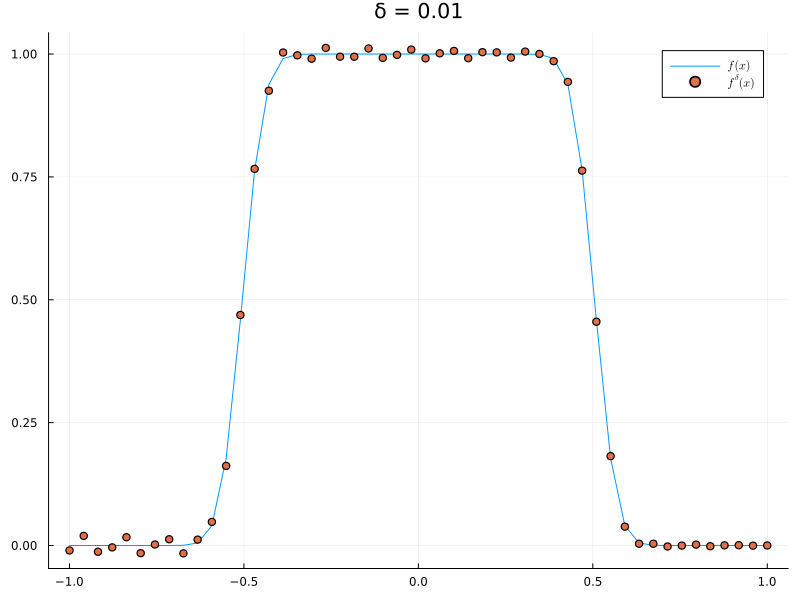

In [6]:
plot( x , f_ , label = L"f(x)" , title = "δ = $(δ)")
scatter!( x , f_noise , label = L"f^δ(x)", size = (800,600))

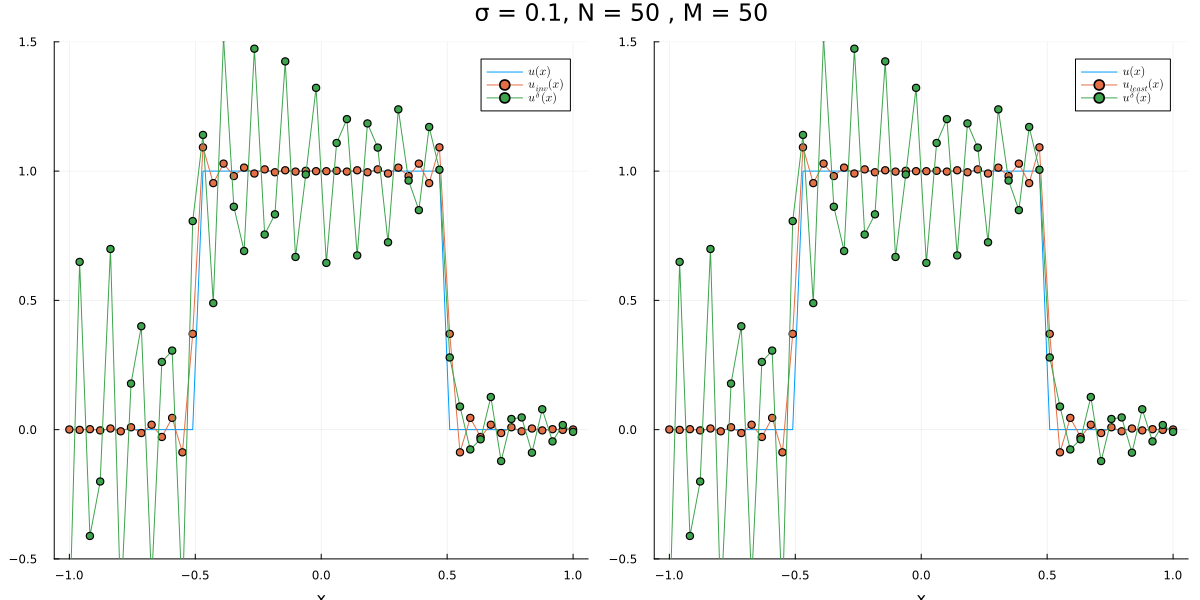

In [7]:
p1 = plot( x , u.(x) , label = L"u(x)")
plot!( x , u_ , label = L"u_{inv}(x)" , marker = :circle)
plot!( x , u_noise , label = L"u^{δ}_{}(x)" , marker = :circle )

p2 = plot( x , u.(x) , label = L"u(x)" )
plot!( x , u_least , label = L"u_{least}(x)", marker = :circle)
plot!( x , u_least_noise , label = L"u^{δ}_{}(x)", marker = :circle)

plot( p1 , p2 , suptitle = "σ = $(.1), N = $(N) , M = $(M)" , xlabel = "x" , size = (1200,600) , ylims = (-.5,1.5))

* ## SVD

$$ f = K u $$

The SVD of $K$ is

$$ f = U \Sigma V^T u$$

$$ u = V \Sigma^{+} U^T f$$

In [8]:
U,Σ,V = svd(K)

σL = .5
mask = Σ .>= σL
Σ_trunc = diagm(vcat( 1 ./ Σ[mask] , zeros(length(Σ) - sum(mask)) ))

u_svd = V * Σ_trunc * transpose(U) * f_;
u_svd_noise = V * Σ_trunc * transpose(U) * f_noise;

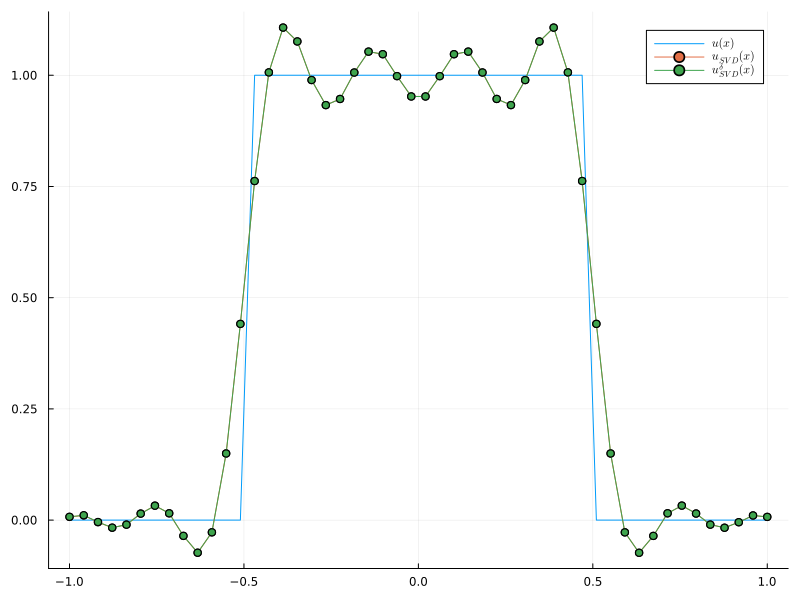

In [9]:
p1 = plot( x , u.(x) , label = L"u(x)" , size = (800,600))
plot!( x , u_svd , label = L"u_{SVD}(x)", marker = :circle)
plot!( x , u_svd_noise , label = L"u^{δ}_{SVD}(x)", marker = :circle)

## Tiknonov regularization

Define 

$$ J(u) = \frac{1}{2} (Ku - f)^T (Ku - f) = \frac{1}{2}(u^T K^T Ku - 2u^TK^T f + f^T f) + \frac{\alpha}{2} u^T u $$

$$ J'(u) = K^T K u -  K^T f + \alpha u$$

$$ J'(u_{min}) = 0 \implies u_{min} =  (K^T K + \alpha I )^{-1} K^T f$$

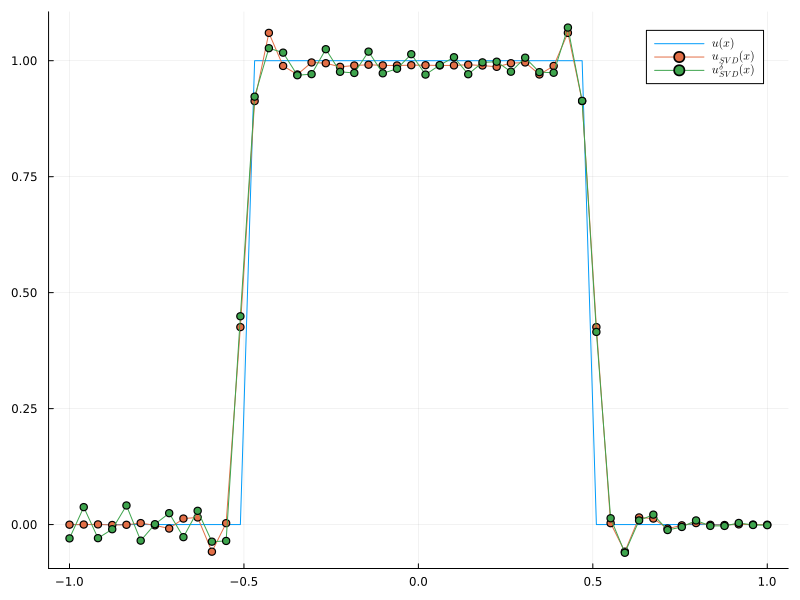

In [10]:
α = 10e-3

u_Tiknonov = inv( transpose(K) * K + α * Matrix(I,M,M) ) * transpose(K) * f_;
u_Tiknonov_noise = inv( transpose(K) * K + α * Matrix(I,M,M) ) * transpose(K) * f_noise;

p1 = plot( x , u.(x) , label = L"u(x)" , size = (800,600) )
plot!( x , u_Tiknonov , label = L"u_{SVD}(x)", marker = :circle)
plot!( x , u_Tiknonov_noise , label = L"u^{δ}_{SVD}(x)" , marker = :circle)

## Fourrier Transform

The convolution theorem states

$$ \mathcal{F}(f) = \mathcal{F}(k) \mathcal{F}(u) $$

Then 

$$ u = \mathcal{F}^{-1} \left( \frac{\mathcal{F}(f)}{\mathcal{F}(k)} \right)$$

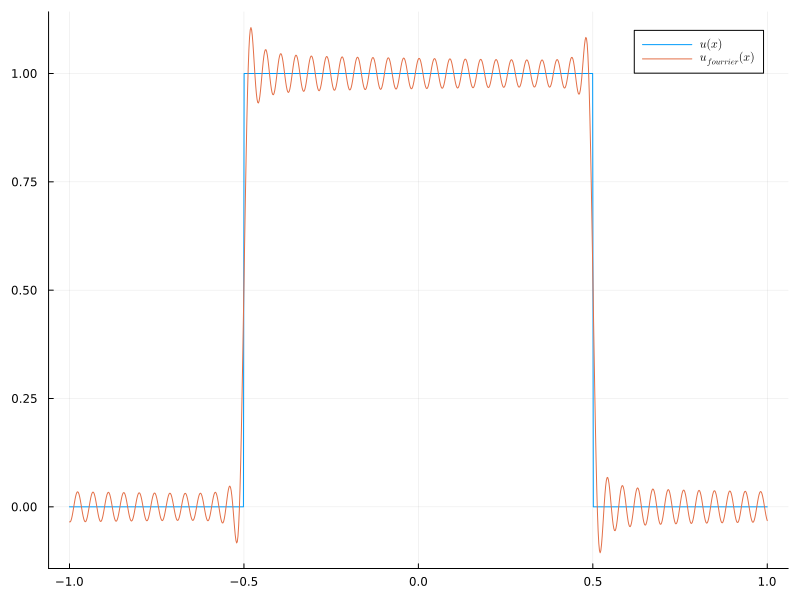

In [11]:
N = 1024
M = 1024

x = range( -1, 1 , N)
y = range( -1, 1 , M)

kernel(x , σ = .05) = exp(-(x ^ 2) / (2 * σ^2)) / (sqrt(2π) * σ)

f_ = f.(x)
K = kernel.(x)
K = K / sum(K)

f_fft = real( ifft( fft( K ) .* fft(u.(x)) ) ) 

f_fourrier = fft(f_fft)
k_fourrier = fft(K) .+ .1e-10
u_fourrier = real( ifft( f_fourrier ./  k_fourrier) )


plot( x , u.(x) , label = L"u(x)", size = (800,600))
plot!(x , u_fourrier , label = L"u_{fourrier}(x)")